# Regression on MLB Data

In [144]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

## Data Analysis

Before plugging in the data into our SVM, it is important to evaluate redundant information to limit multicollinearity. We can find collinearities through the correlation matrix.

     AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  \
0      293    66      1    30   29     14      1     293     66       1   
1      315    81      7    24   38     39     14    3449    835      69   
2      479   130     18    66   72     76      3    1624    457      63   
3      496   141     20    65   78     37     11    5628   1575     225   
4      321    87     10    39   42     30      2     396    101      12   
..     ...   ...    ...   ...  ...    ...    ...     ...    ...     ...   
317    497   127      7    65   48     37      5    2703    806      32   
318    492   136      5    76   50     94     12    5511   1511      39   
319    475   126      3    61   43     52      6    1700    433       7   
320    573   144      9    85   60     78      8    3198    857      97   
321    631   170      9    77   44     31     11    4908   1457      30   

     CRuns  CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary  \
0       30    29     

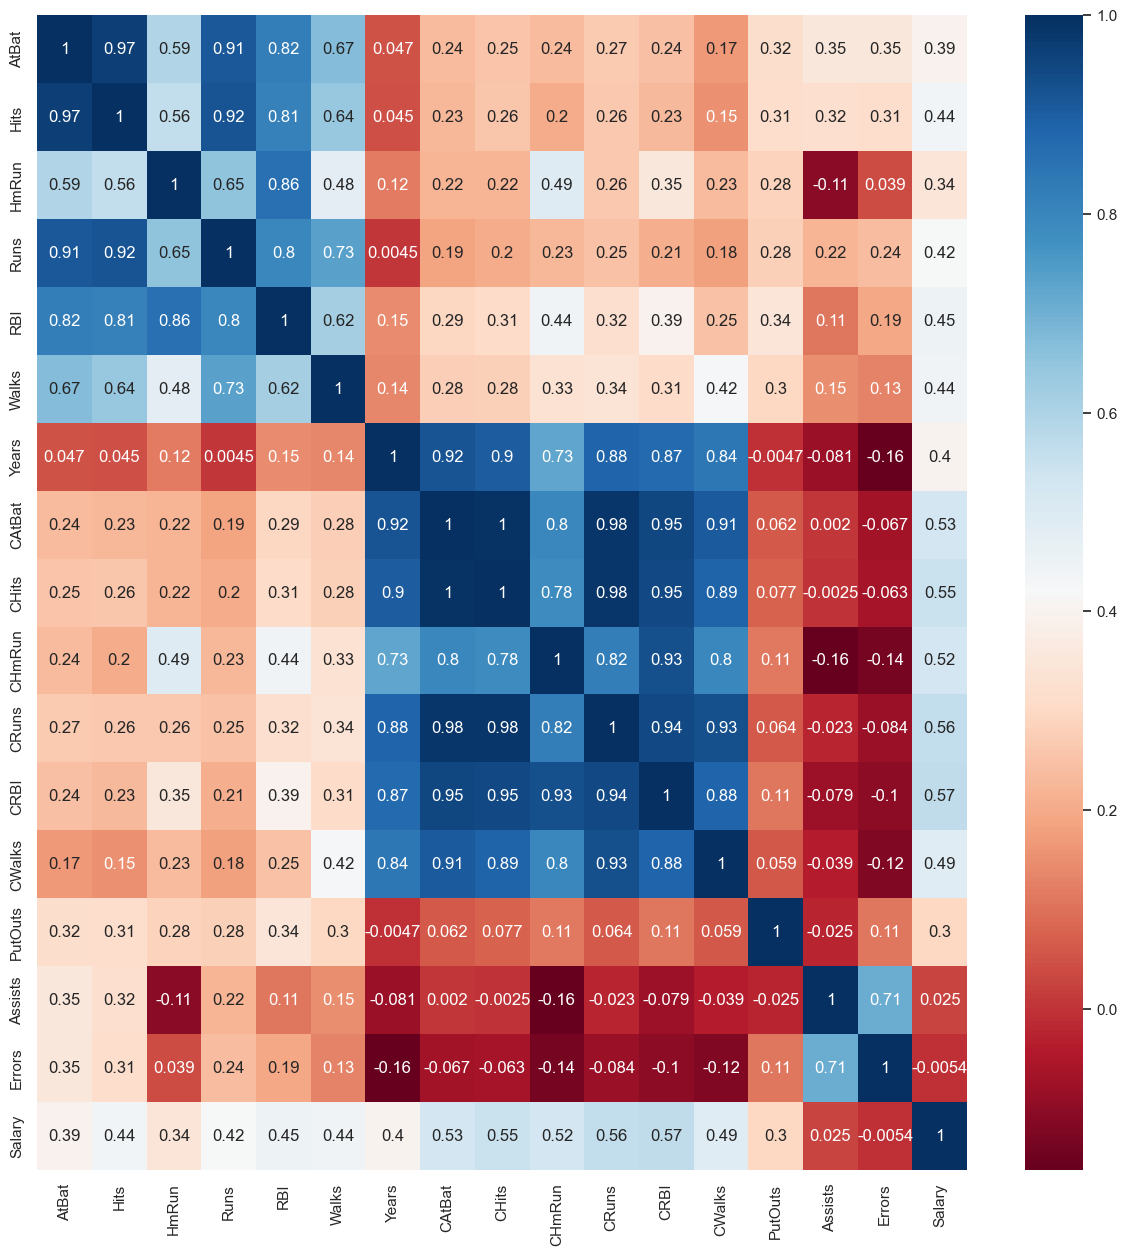

In [145]:
df = pd.read_csv("./Hitters.csv")
print(df)
num_cols = [col for col in df.columns if df[col].dtypes != "O"]
corr = df[num_cols].corr()
sns.set(rc={'figure.figsize': (15, 15)})
sns.heatmap(corr, cmap="RdBu", annot=True)
plt.show()

### Run PCA on highly-correlated features

In [146]:
pca_custat = PCA(n_components=1)
pca_indstat = PCA(n_components=1)
pca_fieldstat = PCA(n_components=1)

custat_df = df[["CAtBat", "CHits", "CHmRun", "CRuns", "CRBI", "CWalks"]]
indstat_df = df[["AtBat", "Hits", "HmRun", "Runs", "RBI", "Walks"]]
fieldstat_df = df[["Assists", "Errors"]]

custat_df_pca = pca_custat.fit_transform(custat_df)
indstat_df_pca = pca_indstat.fit_transform(indstat_df)
fieldstat_df_pca = pca_fieldstat.fit_transform(fieldstat_df)

df_reduced = df.drop(columns=["AtBat", "Hits", "HmRun", "Runs", "RBI", "Walks", "CAtBat", "CHits", "CHmRun", "CRuns", "CRBI", "CWalks", "Assists", "Errors"])
df_reduced = df_reduced.drop(columns=["League", "NewLeague", "Division"])
df_reduced["I_PC1"] = indstat_df_pca
df_reduced["C_PC2"] = custat_df_pca
df_reduced["F_PC3"] = fieldstat_df_pca

# label_mapping_an = {'A': 0, 'N': 1}
# label_mapping_div = {'E': 0, 'W': 1}


# # Apply label encoding to the 'Category' column
# df_reduced['League'] = df_reduced['League'].map(label_mapping_an)
# df_reduced['NewLeague'] = df_reduced['NewLeague'].map(label_mapping_an)
# df_reduced['Division'] = df_reduced['Division'].map(label_mapping_div)
df_reduced.dropna(axis=0, inplace=True)

print(df_reduced)


     Years  PutOuts  Salary       I_PC1        C_PC2       F_PC3
1       14      632   475.0   72.590869   801.168761  -63.814023
2        3      880   480.0 -108.738125 -1059.201154  -24.703570
3       11      200   500.0 -124.894681  3171.420761  -96.026925
4        2      805    91.5   63.304301 -2384.553500  -67.009725
5       11      282   750.0 -221.371087  1777.108228  314.474814
..     ...      ...     ...         ...          ...         ...
317      5      325   700.0 -117.568310    61.626177  -98.025844
318     12      313   875.0 -122.303569  3049.912291  274.332014
319      6       37   385.0  -96.674458 -1030.222990    6.049449
320      8     1314   960.0 -201.645999   587.940371   24.204149
321     11      408  1000.0 -255.582377  2378.079204 -103.023139

[263 rows x 6 columns]


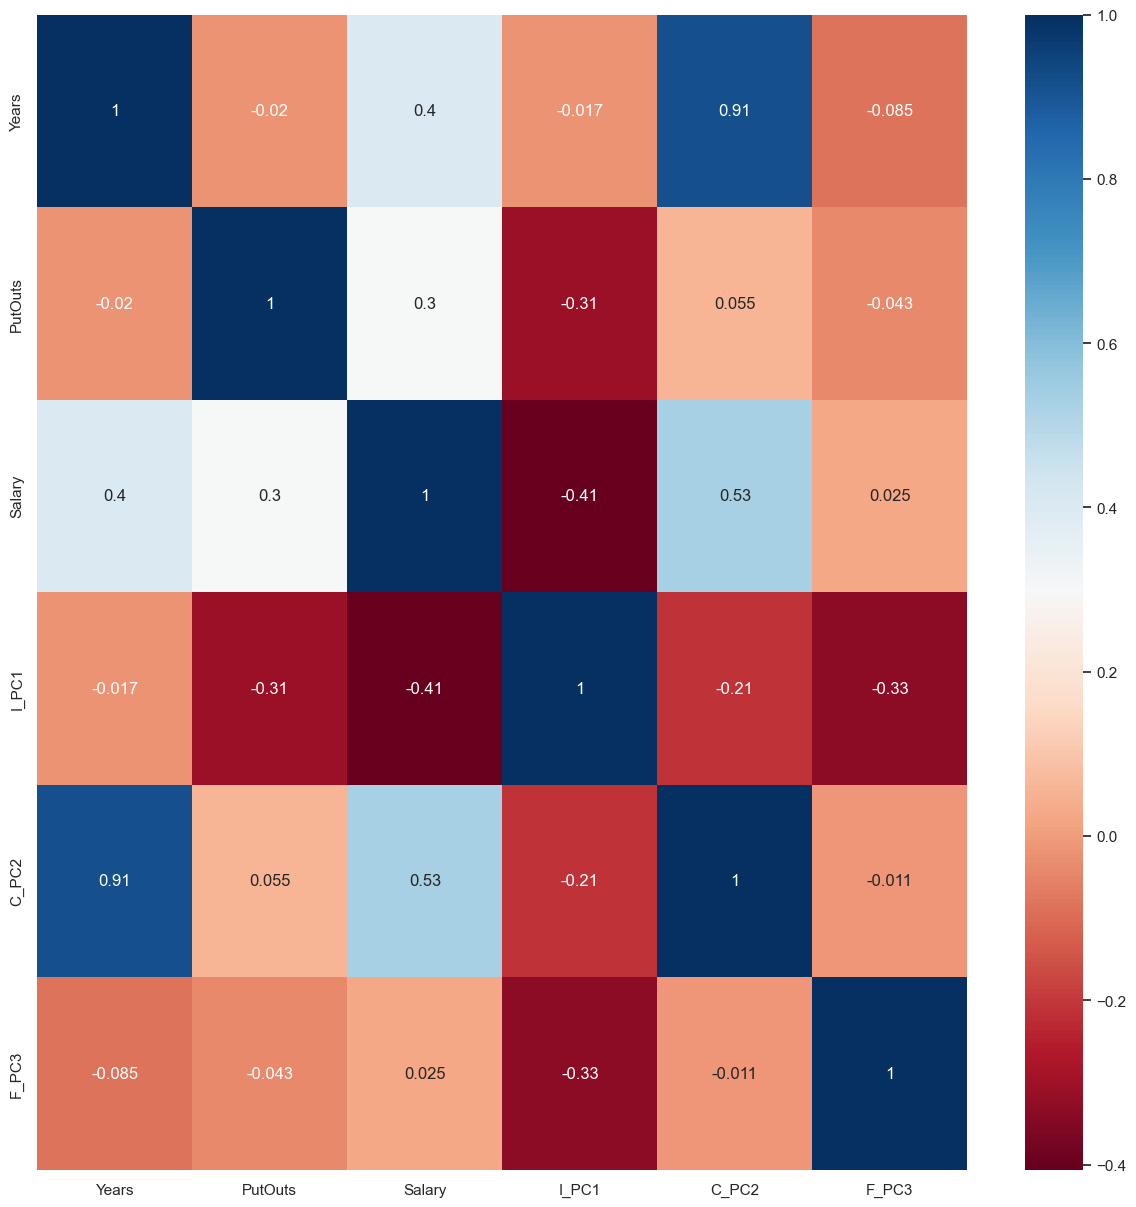

In [147]:
num_cols = [col for col in df_reduced.columns if df_reduced[col].dtypes != "O"]
corr = df_reduced[num_cols].corr()
sns.set(rc={'figure.figsize': (15, 15)})
sns.heatmap(corr, cmap="RdBu", annot=True)
plt.show()

we've reduced the data from 20 columns to 6 columns, which is important, as collinearity can negatively effect the preformance of regression models. Apart from the collinearity effect, I decided to get rid of discretely labeled binary relationships (labels 0 or 1), as this makes the linear regression model more complex and doesn't effect the model preformance that much.

### Create Training and Test Sets

Since we're trying to predict salary, I extract "salary" column from the dataframe, storing it into the label, and dropping that column from the feature data.

In [148]:
df = df_reduced
y = df["Salary"]
X = df.drop(columns="Salary")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

## SVR kernel="linear"

In [149]:
svr_lin = SVR(kernel="linear", C=100, gamma="auto")
svr_lin.fit(X_train, y_train)

SVR(C=100, gamma='auto', kernel='linear')

In [150]:
y_pred = svr_lin.predict(X_test)

### Visualize Multiple Linear Regression

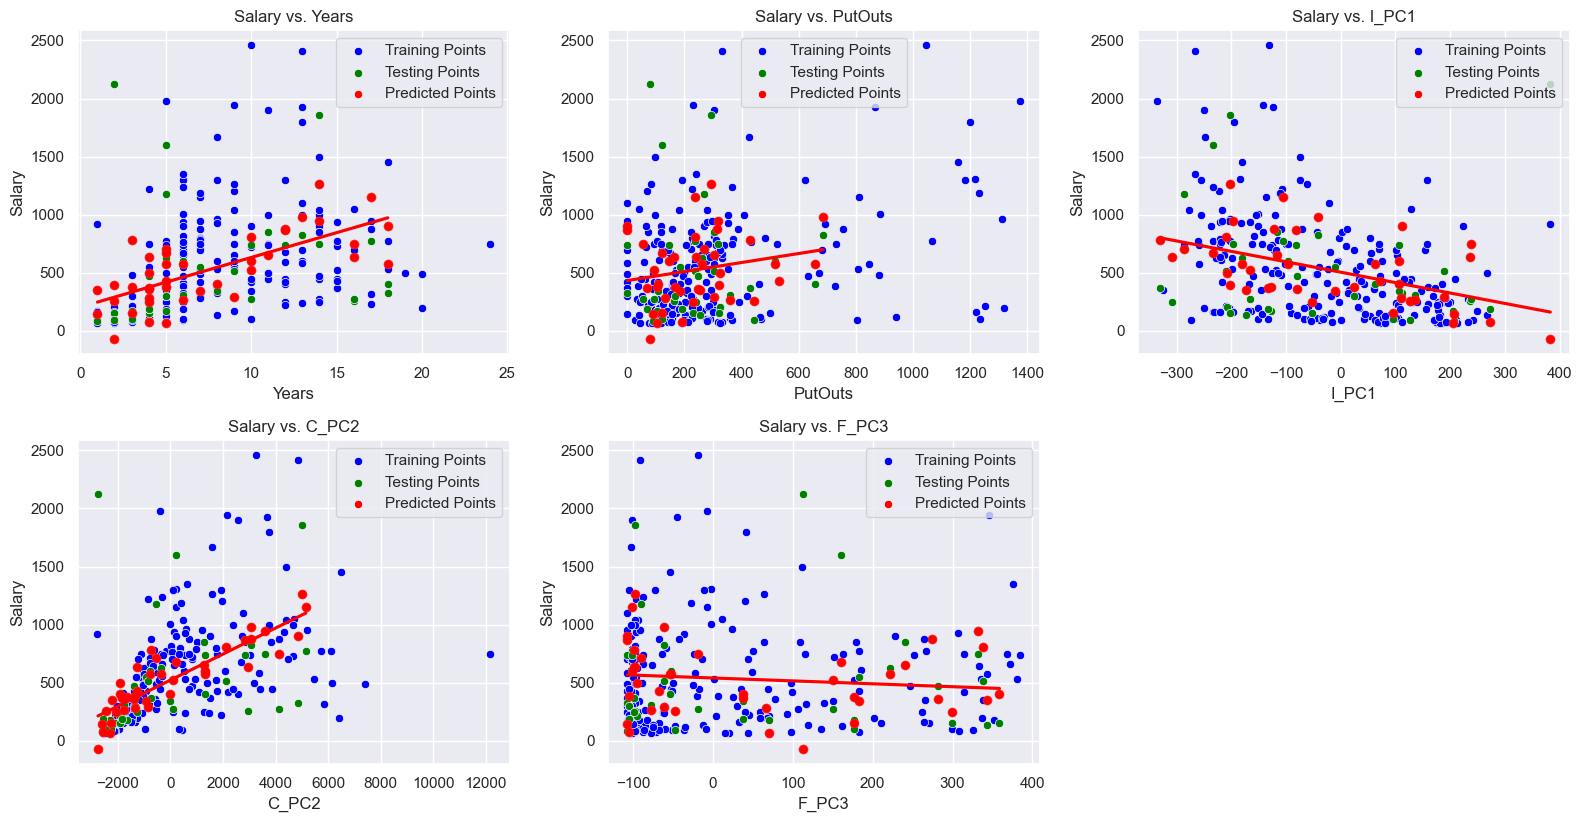

In [151]:
plt.figure(figsize=(16, 12))
independent_variables = X_train.columns
dependent_variable = "Salary"
X_test_numpy = X_test.to_numpy()
for i, col in enumerate(independent_variables, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(data=X_train, x=col, y=y_train, color='blue', label='Training Points')
    sns.scatterplot(data=X_test, x=col, y=y_test, color='green', label='Testing Points')
    sns.scatterplot(data=X_test, x=col, y=y_pred, color='red', label='Predicted Points')
    sns.regplot(x=X_test[col],y=y_pred,ci=None,color ='red')

    plt.title(f'{dependent_variable} vs. {col}')
    plt.xlabel(col)
    plt.ylabel(dependent_variable)

plt.tight_layout()
plt.show()

In [153]:
result_df = pd.DataFrame(columns=["id", "actual", "predicted"])

for i, actual, predicted in zip(y_test.index, y_test, y_pred):
    entry = [i, actual, predicted]
    df_entry = pd.DataFrame(entry, index=["id", "actual", "predicted"]).T
    result_df = pd.concat((result_df, df_entry))
print(result_df)

      id    actual    predicted
0  148.0   850.000   650.862510
0  154.0   277.500   520.554685
0  318.0   875.000   874.420006
0  279.0   150.000   245.484922
0   88.0   260.000   632.126154
0  307.0   277.500   283.362459
0  221.0   210.000   499.202790
0  268.0   140.000   348.565885
0   10.0   517.143   803.999915
0  132.0   325.000   905.685257
0   28.0   625.000   573.613379
0  143.0   773.333  1154.573429
0   61.0   275.000   748.300786
0  276.0   155.000   398.743878
0  241.0   300.000   381.946974
0  267.0   740.000   864.797965
0  108.0  1175.000   708.901678
0    7.0   100.000   150.772088
0  313.0  1600.000   674.693153
0   89.0   475.000   363.101475
0  181.0   737.500   599.129807
0  187.0   365.000   779.271707
0   23.0   600.000   578.278053
0  312.0   550.000   346.226827
0  141.0   250.000   638.806239
0  176.0    86.500   145.132241
0  107.0   750.000   943.785195
0   90.0   431.500   426.399448
0  245.0   400.000   578.999145
0   17.0   175.000    67.146193
0   37.0